## REI602M Machine Learning - Project 1
### Due: *Friday* 20.04.2018

**Objectives**: Allstate Claims Severity

**Name**: Þór Tómasarson, **email: ** tht33@hi.is, **collaborators:** Eggert Jón Magnússon

In [9]:
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

# %matplotlib notebook
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

### Preprocess the data

In [10]:
train = pd.read_csv('train.csv', delimiter=',', index_col='id')
X_train, y_train = train.loc[:, train.columns != 'loss'], train['loss']

In [11]:
# Split train - test
# X_train = pd.get_dummies(X_train, drop_first=True) # Sometimes useful to start with this 

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30)
X_train_origin, y_train_origin = X_train.copy(), y_train.copy()

X_train.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,"131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000"
mean,0.494,0.507,0.498,0.491,0.487,0.491,0.485,0.487,0.486,0.498,0.494,0.494,0.493,0.495
std,0.188,0.208,0.202,0.211,0.209,0.205,0.178,0.200,0.182,0.186,0.210,0.209,0.213,0.222
min,0.000,0.001,0.003,0.177,0.281,0.013,0.070,0.237,0.000,0.000,0.035,0.036,0.000,0.180
25%,0.346,0.358,0.337,0.327,0.281,0.336,0.350,0.313,0.359,0.365,0.314,0.318,0.316,0.295
50%,0.476,0.556,0.528,0.453,0.422,0.441,0.439,0.441,0.441,0.461,0.457,0.462,0.364,0.406
75%,0.627,0.682,0.634,0.652,0.635,0.656,0.591,0.624,0.569,0.615,0.679,0.679,0.690,0.724
max,0.985,0.863,0.944,0.954,0.984,0.997,1.000,0.980,0.994,0.995,0.999,0.998,0.988,0.845


No need to transform any of the continuous attributes. They are all on the interval [0, 1] with reasonable standard deviation, also there are no missing values for the continuous attributes.

The **loss** column has the following statistics {mean: 3037.3, std: 2904.1, min: 0.67, max: 121012.25}. With $min\approx0$, $mean \approx std$ and $max>>std$ $\frac{max}{std}=\frac{121012.25}{2904.1}=41.67$, these numbers indicate a highly skewed data with long tail to the right.

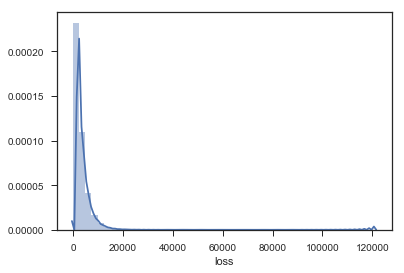

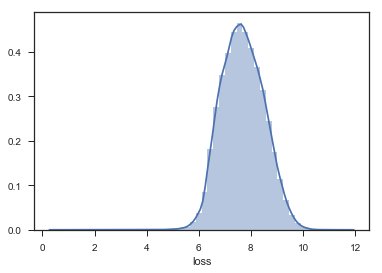

In [284]:
sns.distplot(y_train)
plt.show()

sns.distplot(np.log1p(y_train))
plt.show()

In [307]:
# y_train = np.log1p(y_train)
# y_test = np.log1p(y_test)

The former plot confirms the theory of skewness. With a $log(x + 1)$ transform the **loss** column looks more like the expected (at least for Linear Regression) Gaussian distribution. The $+1$ in $log(x + 1)$ is just to be on the safe side of the floating point cancellation, even though the data indicates that there should not be a need for it (with min $0.67 >> 0$ "in some sense").

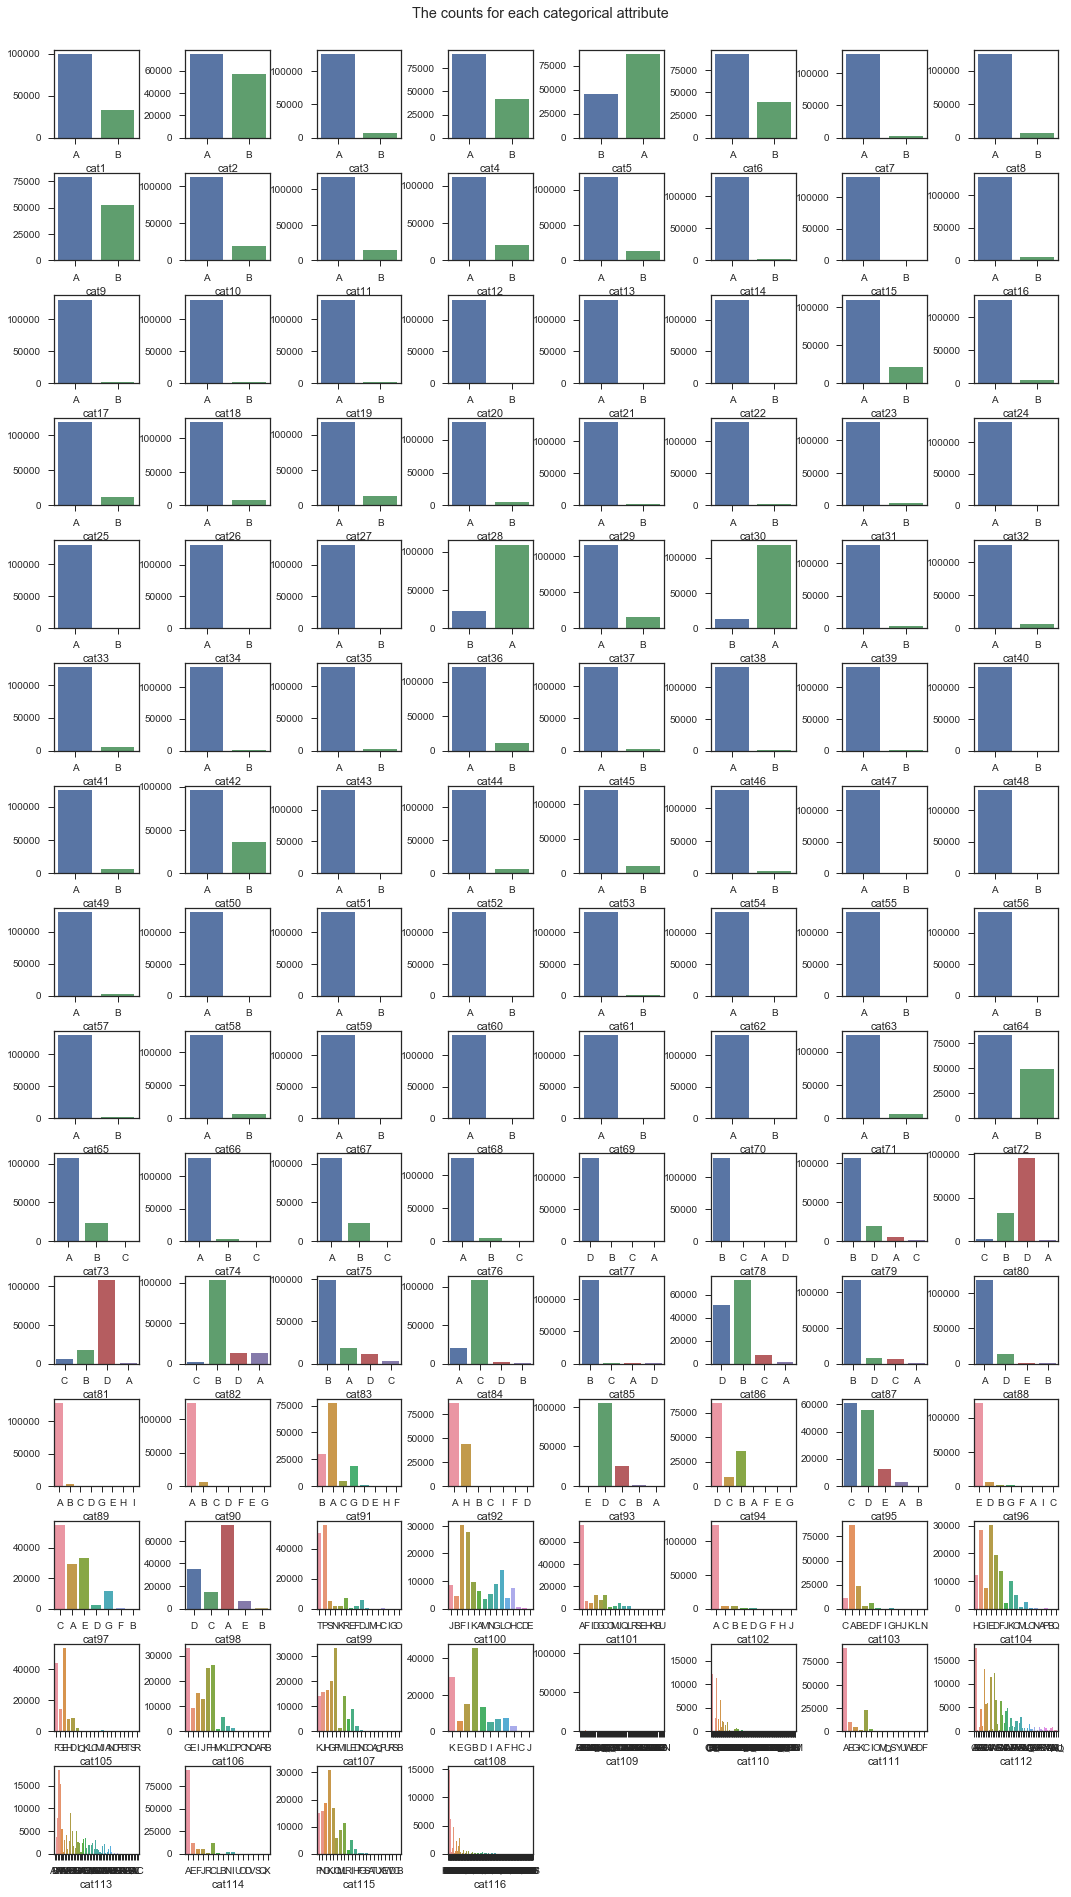

In [344]:
# Count the number of items for each categorical attribute
cat_index = [x for x in X_train.columns if x.startswith('cat')]

n = 8
r = len(cat_index)//n + 1
plt.figure(figsize=(18, 30))
for i in range(r):
    for j in range(n if i != r-1
                     else ((len(cat_index)%n))
                  ):
#         print(i, j)
        if (i*n + j + 1) > len(cat_index):
            break
        plot = plt.subplot(r, n, (i*n + j + 1))
        # sns.boxplot(x=features[axIndex], y="loss", data=train_data, ax=axList[axIndex])
        ax = sns.countplot(x=cat_index[i*n + j], data=X_train)
        plt.subplots_adjust(wspace=0.55, hspace=0.4, top=0.96)
        ax.set_ylabel('')
plt.suptitle('The counts for each categorical attribute')
plt.show()

In [365]:
cat_index = [x for x in X_train.columns if x.startswith('cat')]

# All attributes have at least few thousands of each items
# counts = X_train[cat_index].apply(pd.value_counts)
# counts[cat_index[:-100]].dropna(axis=0, how='all')

def letter_to_numb(series):
    ret = []
    for c in series:
        if len(c) == 1:
            ret.append(ord(c.lower()) - 96)
        else:
            ret.append('')
            for s in c:
                ret[-1] += str(ord(s.lower()) - 96)
            ret[-1] = int(ret[-1])
    return ret
            
    
integer_categories = X_train[cat_index].apply(letter_to_numb)

corr = integer_categories.corr(method='kendall') # spearman and kendall-tau mostly agree

In [376]:
y_to_cat_correlation = []
for col in integer_categories:
    y_corr = y_train.corr(integer_categories[col], method='kendall')
    if np.abs(y_corr) > 0.2:
        y_to_cat_correlation.append((col, y_train.corr(integer_categories[col], method='kendall')))

print(y_to_cat_correlation)

corr_matrix = integer_categories[[col[0] for col in y_to_cat_correlation]].corr(method='kendall')
(corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

# Drop cat9 and cat101 use only ['cat1', 'cat2', 'cat9', 'cat10', 'cat12', 'cat79', 'cat80', 'cat81', 'cat87', 'cat101']

[('cat1', -0.22023429508004846), ('cat2', 0.21548318933116084), ('cat9', 0.20411839438059776), ('cat10', 0.24201660806967559), ('cat12', 0.27544358263058338), ('cat79', 0.28714663482930947), ('cat80', -0.38211584532111043), ('cat81', -0.22670349612048346), ('cat87', 0.25865198543790752), ('cat101', 0.25089188806653273)]


cat2   cat9     0.932
       cat101   0.868
cat9   cat101   0.827
cat12  cat101   0.589
cat10  cat101   0.588
       cat12    0.568
cat79  cat80    0.519
cat2   cat12    0.483
       cat10    0.480
cat80  cat87    0.470
cat9   cat10    0.469
       cat12    0.434
cat79  cat87    0.415
cat80  cat81    0.305
cat10  cat87    0.271
cat12  cat87    0.255
cat87  cat101   0.247
cat12  cat80    0.235
cat10  cat80    0.229
cat80  cat101   0.227
cat2   cat87    0.221
cat9   cat87    0.218
cat1   cat80    0.210
cat2   cat80    0.198
cat9   cat80    0.193
cat10  cat79    0.186
cat12  cat79    0.180
cat79  cat101   0.176
       cat81    0.173
cat1   cat101   0.168
       cat2     0.167
       cat9     0.159
cat2   cat79    0.157
cat9   cat79    0.155
cat1   cat79    0.144
cat81  cat87    0.144
cat1   cat12    0.144
       cat10    0.142
       cat87    0.136
       cat81    0.095
cat12  cat81    0.060
cat10  cat81    0.038
cat81  cat101   0.021
cat9   cat81    0.006
cat2   cat81    0.001
dtype: flo

In [135]:
corr_matrix = corr.abs()
sorted_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

In [144]:
sorted_corr[sorted_corr > 0.7]

cat7    cat89    0.999
cat3    cat90    0.998
cat8    cat102   0.991
cat4    cat111   0.934
cat2    cat9     0.932
cat6    cat50    0.926
        cat114   0.925
cat5    cat103   0.925
cat86   cat99    0.888
cat2    cat101   0.868
cat50   cat114   0.866
cat8    cat66    0.862
cat66   cat102   0.855
cat9    cat101   0.827
cat7    cat57    0.812
cat57   cat89    0.812
cat86   cat98    0.790
cat3    cat16    0.788
cat16   cat90    0.787
cat91   cat92    0.779
cat86   cat115   0.741
cat107  cat115   0.733
cat99   cat115   0.731
        cat108   0.726
cat86   cat108   0.704
cat98   cat99    0.702
dtype: float64

In [295]:
cat_correlated = list(sorted_corr[sorted_corr > 0.1].index.get_level_values(0).unique())
print(cat_correlated)
X_train = X_train.drop(columns=cat_correlated)
X_test = X_test.drop(columns=cat_correlated)

['cat7', 'cat3', 'cat8', 'cat4', 'cat2', 'cat6', 'cat5', 'cat86', 'cat50', 'cat66', 'cat9', 'cat57', 'cat16', 'cat91', 'cat107', 'cat99', 'cat98', 'cat104', 'cat77', 'cat78', 'cat23', 'cat36', 'cat12', 'cat10', 'cat14', 'cat108', 'cat25', 'cat40', 'cat38', 'cat24', 'cat79', 'cat53', 'cat37', 'cat84', 'cat43', 'cat27', 'cat11', 'cat29', 'cat44', 'cat80', 'cat13', 'cat82', 'cat65', 'cat26', 'cat97', 'cat51', 'cat87', 'cat19', 'cat95', 'cat55', 'cat49', 'cat52', 'cat61', 'cat106', 'cat101', 'cat33', 'cat88', 'cat92', 'cat17', 'cat46', 'cat28', 'cat76', 'cat41', 'cat105', 'cat60', 'cat47', 'cat1', 'cat18', 'cat31', 'cat42', 'cat34', 'cat54', 'cat39', 'cat103', 'cat75', 'cat85', 'cat45', 'cat59', 'cat72', 'cat30', 'cat67', 'cat71', 'cat32', 'cat58', 'cat96', 'cat94', 'cat21', 'cat83', 'cat90', 'cat69', 'cat73', 'cat109', 'cat81', 'cat63', 'cat20', 'cat111', 'cat62', 'cat48', 'cat100', 'cat68', 'cat64']


In [395]:
useful_columns = ['cat80'] # ['cat1', 'cat2', 'cat9', 'cat10', 'cat12', 'cat79', 'cat80', 'cat81', 'cat87', 'cat101']
useful_columns.extend(cont_index())

X_train = X_train[useful_columns]
X_test = X_test[useful_columns]

There are few categorical attributes that have next to no distribution, that is to say all values have the same label except very few. These few items could be a rare event but they could also be "uninteresting" and then consequently will increase the number of attributes without the need for it, which could damage the performance for some of the models. In order to be able to distinguish between whether these are rare interesting events or "uninteresting" then we would need to know the true nature of these attributes (would need have the field knowledge). Since we can not know what these attributes represent then for safety measures we keep them all when performing the one-hot encoding.

In [12]:
# One-hot transform
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

additional_columns = set(X_test.columns) - set(X_train.columns)
X_test = X_test.drop(columns=additional_columns)

missing_columns = set(X_train.columns) - set(X_test.columns)
for col in missing_columns:
    X_test[col] = 0

Correlations:
      cont1  cont10  cont11  cont12  cont13  cont14  cont2  cont3  cont4  \
loss -0.009   0.018   0.098   0.097  -0.003   0.020  0.140  0.110 -0.038   

      cont5  cont6  cont7  cont8  cont9  
loss -0.011  0.041  0.118  0.030  0.016  


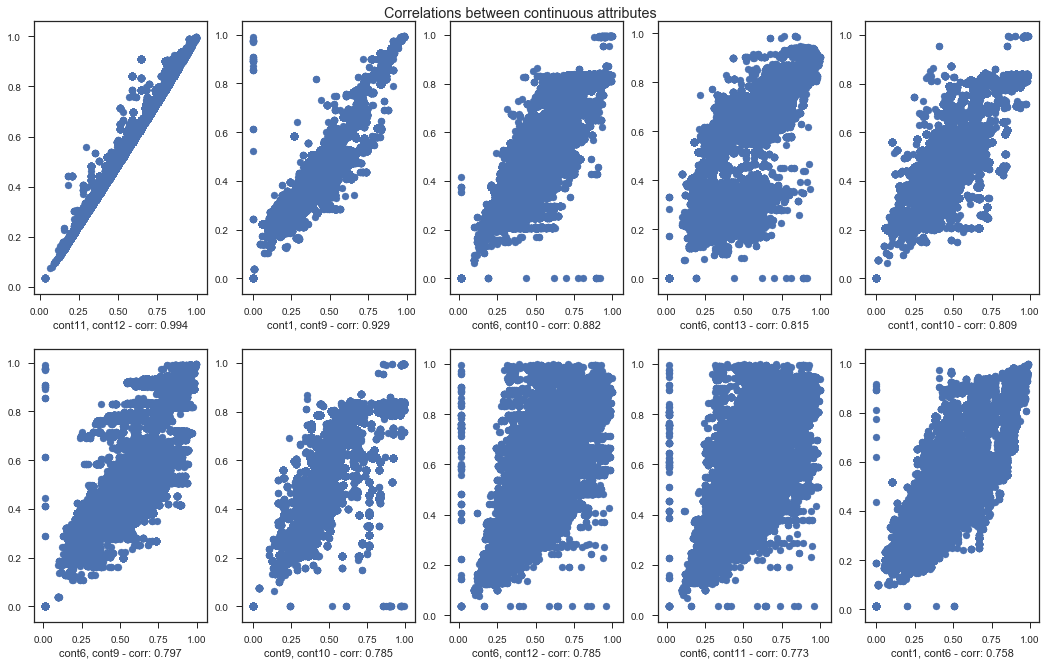


There are 10 correlated features with (absolute) correlation higher than 0.75


In [7]:
cont_index = lambda : [x for x in X_train.columns if x.startswith('cont')]

print('Correlations:')
corr = {}
corr_cont_loss = {}
for idx, col_1 in enumerate(cont_index()):
    corr[(col_1, 'loss')] = X_train[col_1].corr(y_train)
    corr_cont_loss[col_1] = corr[(col_1, 'loss')]
    
    for col_2 in cont_index()[idx+1:]:
        if col_1 != col_2:
            corr[(col_1, col_2)] = X_train[col_1].corr(X_train[col_2])
print(pd.DataFrame(data=corr_cont_loss, index=['loss']))
            
limit = 0.75
correlated = {}
for key, value in corr.items():
    if np.abs(value) > limit:
        correlated[key] = value

import operator
correlated = sorted(correlated.items(), key=operator.itemgetter(1))
correlated.reverse()

plt.figure(figsize=(18, 10))
i = 0
for key, value in correlated:
    plot = plt.subplot(2, 5, i + 1)
    plt.scatter(X_train[key[0]], X_train[key[1]], s=40, alpha=0.5)
    # ax = sns.jointplot(x=key[0], y=key[1], data=X_train)
    plot.set_xlabel(f'{key[0]}, {key[1]} - corr: {value:.3f}')
    plt.subplots_adjust(top=0.96)
    i += 1
plt.suptitle('Correlations between continuous attributes')
plt.show()

print(f'\nThere are {len(correlated)} correlated features with (absolute) correlation higher than {limit}')

There is no single continuous attribute with high correlation with the output (loss - attribute).

There are 10 correlated pairs (correlation > 0.75) out of the 14x14 combinations of the continuous attributes. The correlation is high and visible for {cont1-cont9, cont6-cont10, cont1-cont10, cont6-cont9, cont9-cont10, cont1-cont6} and extremely high for {cont11-cont12}. This indicates that PCA could be very useful, or one could even consider dropping the following attributes {cont12, cont6, cont9, cont10}. Thus reducing the number of continuous attributes down to 10 attributes.

In [389]:
X_train.drop(['cont12', 'cont6', 'cont9', 'cont10'], axis=1, inplace=True)
X_test.drop(['cont12', 'cont6', 'cont9', 'cont10'], axis=1, inplace=True)

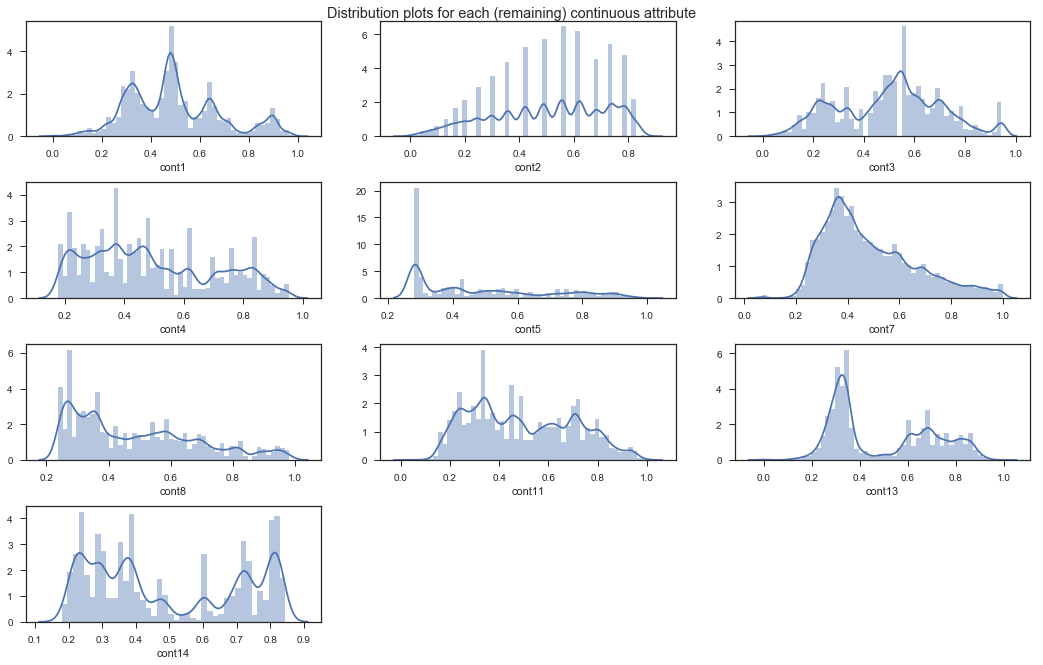

In [9]:
plt.figure(figsize=(18, 10))

n = len(cont_index())
for i, col in enumerate(cont_index()):
    plot = plt.subplot(n//3+1, 3, i + 1)
    sns.distplot(X_train[col])
    plot.set_xlabel(f'{col}')
    plt.subplots_adjust(hspace=0.4, top=0.96)
plt.suptitle('Distribution plots for each (remaining) continuous attribute')
plt.show()

Most of these continuous attributes look a bit discreet, it might be worth validating that these are indeed interval or ratio numbers (not just ordinal).

In [13]:
# TOOD: Apply the same function on both the test and train datasets
def preprocess_data(X, y):
    pass

# X_train_changed = X_train.copy()
# X_train, y_train = preprocess_data(X_train_origin, y_train_origin)
# assert X_train == X_train_changed

# X_test, y_test = preprocess_data(X_test, y_test)
n_train, m_train = X_train.shape
n_test, m_test = X_test.shape

In [194]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001), # Try Elastic-Net með tveimur stikum
    # non-linear
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=1, n_jobs=-1),
    "SVR": SVR(),
    "BaggingRegressor": BaggingRegressor(n_jobs=-1),
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1, n_estimators=50),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_jobs=-1, n_estimators=100),
} # Relu og dropout

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test)
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tError: {error:.3f}')
    
# This here is with no log-transform

LinearRegression:
	Time elapsed for fitting of model 24.355 sec
	Time elapsed for prediction 0.434 sec
	Error: 1655603234.882
Ridge:
	Time elapsed for fitting of model 5.799 sec
	Time elapsed for prediction 0.414 sec
	Error: 1302.587
Lasso:


C:\Users\Notandi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Time elapsed for fitting of model 200.994 sec
	Time elapsed for prediction 0.426 sec
	Error: 1305.573
KNeighborsRegressor:
	Time elapsed for fitting of model 95.604 sec
	Time elapsed for prediction 4662.196 sec
	Error: 1747.104
SVR:
	Time elapsed for fitting of model 20007.080 sec
	Time elapsed for prediction 10160.075 sec
	Error: 1755.613
BaggingRegressor:
	Time elapsed for fitting of model 134.787 sec
	Time elapsed for prediction 12.849 sec
	Error: 1295.292
RandomForestRegressor:
	Time elapsed for fitting of model 475.075 sec
	Time elapsed for prediction 1.643 sec
	Error: 1245.477
ExtraTreesRegressor:
	Time elapsed for fitting of model 1922.238 sec
	Time elapsed for prediction 3.084 sec
	Error: 1281.961


In [ ]:
import sys

# alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
print("GradientBoostingRegressor")
t_0 = time.time()
y_test_predict = dict()
for n in np.r_[250, np.arange(500, 2001, 500)]:
    try:
        a, lr, sl, ss, md = 0.5, 0.1, 20, 20, 6
        estimator = GradientBoostingRegressor(loss='huber', alpha=a,
                                n_estimators=n, max_depth=md,
                                learning_rate=lr, min_samples_leaf=sl,
                                min_samples_split=ss,
                                criterion=crit)
        t_1 = time.time()
        name = f"loss='huber', alpha={a}, n_estimators={n}, max_depth={md}, \
learning_rate={lr}, min_samples_leaf={sl}, min_samples_split={ss}"
        print(f"{name}")
        estimator.fit(X_train, y_train)

        t_2 = time.time()
        print(f'\tTime elapsed for fitting of model {t_2 - t_1:.3f} sec')
        y_test_predict[name] = estimator.predict(X_test)
        error = mean_absolute_error(y_test, y_test_predict[name])
        print(f'\tTime elapsed for prediction {time.time() - t_2:.3f} sec')
        print(f'\tError: {error:.3f}')
    except:
        print("Unexpected error:", sys.exc_info())
            
# No columns dropped

GradientBoostingRegressor
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Time elapsed for fitting of model 2494.845 sec
	Time elapsed for prediction 1.809 sec
	Error: 1148.185
loss='huber', alpha=0.5, n_estimators=500, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Time elapsed for fitting of model 4874.614 sec
	Time elapsed for prediction 2.963 sec
	Error: 1145.833
loss='huber', alpha=0.5, n_estimators=1000, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Time elapsed for fitting of model 9793.299 sec
	Time elapsed for prediction 5.360 sec
	Error: 1147.819
loss='huber', alpha=0.5, n_estimators=1500, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Time elapsed for fitting of model 14791.527 sec
	Time elapsed for prediction 7.492 sec
	Error: 1152.220
loss='huber', alpha=0.5, n_estimators=2000, max_depth=6, learning_rate=0.1, min_samples

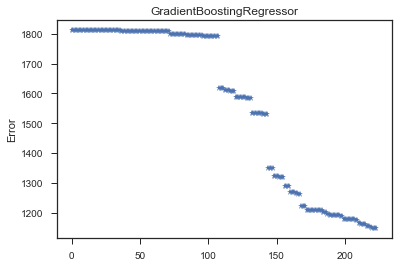

loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Error: 1149.09
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Error: 1149.125
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10
	Error: 1149.238
loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20
	Error: 1150.382
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10
	Error: 1153.54
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20
	Error: 1154.371
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10
	Error: 1155.83
loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_

In [17]:
gradient_boosting_error = {"loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1532.987, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1532.987, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1532.679, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1617.870, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1587.853, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1532.679, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.692, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.692, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.692, "loss='huber', alpha=0.9, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.795, "loss='huber', alpha=0.9, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.762, "loss='huber', alpha=0.9, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.692, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1535.546, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1535.546, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1535.529, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1612.133, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1587.346, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1535.529, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.711, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.711, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.711, "loss='huber', alpha=0.5, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.808, "loss='huber', alpha=0.5, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.768, "loss='huber', alpha=0.5, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.711, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1533.252, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1533.252, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1531.789, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1609.175, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1583.347, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1531.789, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1811.706, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1811.706, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1811.707, "loss='huber', alpha=0.1, n_estimators=5, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.805, "loss='huber', alpha=0.1, n_estimators=5, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.770, "loss='huber', alpha=0.1, n_estimators=5, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1811.707, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1290.901, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1210.449, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1290.901, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1210.439,
                           "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1290.965, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1209.183, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1350.012, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1290.965, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1209.185, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.126, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.126, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.126, "loss='huber', alpha=0.9, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1809.154, "loss='huber', alpha=0.9, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.822, "loss='huber', alpha=0.9, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.126, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1268.964, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1192.706, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1268.964, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1193.041, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1267.985, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1193.603, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1322.774, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1267.985, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1193.603, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.309, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.309, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.309, "loss='huber', alpha=0.5, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1809.283, "loss='huber', alpha=0.5, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.882, "loss='huber', alpha=0.5, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.309, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1264.335, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1195.187, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1264.335, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1195.280, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1265.041, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1193.988, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1319.222, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1265.041, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1193.598, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1808.268, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1808.268, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1808.269, "loss='huber', alpha=0.1, n_estimators=50, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1809.230, "loss='huber', alpha=0.1, n_estimators=50, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.894, "loss='huber', alpha=0.1, n_estimators=50, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1808.269, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1223.694, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1190.403, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1165.056, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1223.694, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1190.403, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1165.666, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1223.130, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1191.399, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1162.558, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1223.130, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1191.399,
                           "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1162.540, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1792.637, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1792.637, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1792.638, "loss='huber', alpha=0.9, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1797.752, "loss='huber', alpha=0.9, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1796.096, "loss='huber', alpha=0.9, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1792.638, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1209.314, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1179.838, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1149.125, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1209.314, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1179.838, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1150.382, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1209.499, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1179.457, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1149.238, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1209.499, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1179.457, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1149.090, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1793.512, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1793.512, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1793.509, "loss='huber', alpha=0.5, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1798.308, "loss='huber', alpha=0.5, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1796.295, "loss='huber', alpha=0.5, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1793.509, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1178.866, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1155.830, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1179.064, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1155.997, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1178.742, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1153.540, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1208.817, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1178.742, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.1, min_samples_leaf=20, min_samples_split=20": 1154.371, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=10": 1793.199, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=10, min_samples_split=20": 1793.199, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=10": 1793.194, "loss='huber', alpha=0.1, n_estimators=250, max_depth=2, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1797.949, "loss='huber', alpha=0.1, n_estimators=250, max_depth=3, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1796.003, "loss='huber', alpha=0.1, n_estimators=250, max_depth=6, learning_rate=0.0001, min_samples_leaf=20, min_samples_split=20": 1793.194, "loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1202.341, "loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1177.162, "loss='huber', alpha=0.9, n_estimators=500, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=10": 1162.143, "loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1202.341, "loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1177.176, "loss='huber', alpha=0.9, n_estimators=500, max_depth=6, learning_rate=0.1, min_samples_leaf=10, min_samples_split=20": 1162.451, "loss='huber', alpha=0.9, n_estimators=500, max_depth=2, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1201.796, "loss='huber', alpha=0.9, n_estimators=500, max_depth=3, learning_rate=0.1, min_samples_leaf=20, min_samples_split=10": 1177.632}

error = list(gradient_boosting_error.values())
error.sort()
error.reverse()
plt.plot(error, '*')
plt.title("GradientBoostingRegressor")
plt.ylabel("Error")
plt.show()

error = sorted(gradient_boosting_error.items(), key=lambda item: item[1], reverse=False)
for e in error[:30]:
    print(f"{e[0]}\n\tError: {e[1]}")


In [356]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
} # Relu og dropout

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test)
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tTest error: {error:.3f}')
    print(f'\tTrain error: {mean_absolute_error(y_train, estimator.predict(X_train)):.3f}')
    
# The coefficients
# print('Coefficients: \n', regr.coef_)
print('--------------------------')
print('Features    | Coefficients')
print('--------------------------')
good_features = []
for l, c in zip(X_train.columns, estimator.coef_):
    print('{0} {1}| {2:.2f}'.format(l, ' '*(11 - len(l)), c))
    good_features.append(l)

LinearRegression:
	Time elapsed for fitting of model 0.963 sec
	Time elapsed for prediction 0.068 sec
	Test error: 1760.585
	Train error: 1776.662
--------------------------
Features    | Coefficients
--------------------------
cont1       | -1994.19
cont2       | 1633.05
cont3       | 604.26
cont4       | -254.57
cont5       | 87.94
cont6       | -1009.15
cont7       | 1927.96
cont8       | 305.77
cont9       | 1776.32
cont10      | 120.64
cont11      | 149.66
cont12      | 180.40
cont13      | -534.24
cont14      | 32.61
cat100_B    | 1328.06
cat100_C    | 3098.84
cat100_D    | 491.07
cat100_E    | 3908.55
cat100_F    | 1373.02
cat100_G    | 2980.68
cat100_H    | 2190.81
cat100_I    | 168.02
cat100_J    | 288.97
cat100_K    | 954.77
cat100_L    | 2315.20
cat100_M    | 3014.65
cat100_N    | 1305.01
cat100_O    | 1766.59
cat104_B    | -688.58
cat104_C    | -742.04
cat104_D    | -526.01
cat104_E    | -445.61
cat104_F    | -466.53
cat104_G    | -381.71
cat104_H    | -195.60
cat104_I    |

In [301]:
print('--------------------------')
print('Features    | Coefficients')
print('--------------------------')
good_features = []
for l, c in zip(X_train.columns, estimator.coef_):
    if c > 4:
        print('{0} {1}| {2:.2f}'.format(l, ' '*(11 - len(l)), c))
        good_features.append(l)

--------------------------
Features    | Coefficients
--------------------------
cat89_H     | 1147072544680.64
cat110_BD   | 7933225885142.30
cat113_AL   | 4062025754906.40
cat113_B    | 1719362805810.86
cat113_BE   | 219552726000.07
cat113_BI   | 116591057212.03
cat113_BL   | 134689000856.47
cat113_P    | 517456626706.32
cat113_V    | 567319489554.08
cat116_IX   | 1202250310849.25
cat116_JP   | 4018109854.15
cat116_U    | 4018109854.33


In [302]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
} # Relu og dropout

# black_list = ['cat89_H', 'cat102_H', 'cat110_BD', 'cat113_AL', 'cat113_BE', 'cat113_BI', 'cat113_BL', 'cat113_G', 'cat113_T', 'cat113_U', 'cat115_B', 'cat115_C', 'cat115_D', 'cat115_E', 'cat116_AF', 'cat116_EQ', 'cat116_J', 'cat116_JA', 'cat116_JO', 'cat116_JP', 'cat116_U', 'cat116_V', 'cat116_X']
black_list = good_features
y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train.drop(black_list, axis=1), y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = np.expm1(estimator.predict(X_test.drop(black_list, axis=1)))
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tTest error: {error:.3f}')
    print(f'\tTrain error: {mean_absolute_error(y_train, np.expm1(estimator.predict(X_train.drop(black_list, axis=1)))):.3f}')
    
# The coefficients
# print('Coefficients: \n', regr.coef_)
print('--------------------------')
print('Features    | Coefficients')
print('--------------------------')
good_features = []
for l, c in zip(X_train.drop(black_list, axis=1).columns, estimator.coef_):
    print('{0} {1}| {2:.2f}'.format(l, ' '*(11 - len(l)), c))
    good_features.append(l)

LinearRegression:
	Time elapsed for fitting of model 9.511 sec
	Time elapsed for prediction 0.336 sec
	Test error: 2861.802
	Train error: 2297.019
--------------------------
Features    | Coefficients
--------------------------
cont1       | 0.01
cont2       | 0.28
cont3       | 0.21
cont4       | -0.10
cont5       | -0.05
cont7       | -0.07
cont8       | 0.12
cont11      | -0.01
cont13      | -0.01
cont14      | -0.04
cat15_B     | 0.07
cat22_B     | -0.03
cat35_B     | 0.48
cat56_B     | 0.20
cat70_B     | -0.13
cat74_B     | 0.08
cat74_C     | 0.43
cat89_B     | 0.98
cat89_C     | 0.95
cat89_D     | 0.93
cat89_E     | -0.03
cat89_I     | -0.03
cat93_B     | 0.54
cat93_C     | 0.67
cat93_D     | 0.65
cat93_E     | 0.82
cat102_B    | 0.22
cat102_C    | 0.20
cat102_D    | 0.33
cat102_E    | 0.33
cat102_F    | 0.79
cat102_G    | 1.05
cat102_H    | 2.00
cat102_J    | 1.01
cat110_AA   | -0.24
cat110_AB   | -0.12
cat110_AC   | -0.00
cat110_AD   | -0.20
cat110_AE   | -0.22
cat110_AF   | -0

In [397]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test)
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tTest error: {error:.3f}')
    print(f'\tTrain error: {mean_absolute_error(y_train, estimator.predict(X_train)):.3f}')

# Using here all continuous attributes and 'cat80' as well

LinearRegression:
	Time elapsed for fitting of model 0.115 sec
	Time elapsed for prediction 0.016 sec
	Test error: 1639.313
	Train error: 1629.506


In [357]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test)
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tTest error: {error:.3f}')
    print(f'\tTrain error: {mean_absolute_error(y_train, estimator.predict(X_train)):.3f}')
    
# Using here: ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cat100', 'cat104', 'cat112']

LinearRegression:
	Time elapsed for fitting of model 0.793 sec
	Time elapsed for prediction 0.063 sec
	Test error: 1760.585
	Train error: 1776.662


In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF

# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
}


    
# n = 4000
# permut = np.random.permutation(X_train.shape[0])[:n]
# X_train_ = X_train.iloc[permut, :]
# y_train_ = y_train.iloc[permut]
# permut = np.random.permutation(X_test.shape[0])[:n]
# X_test_ = X_test.iloc[permut, :]
# y_test_ = y_test.iloc[permut]

X_train_ = X_train
y_train_ = y_train
X_test_ = X_test
y_test_ = y_test
    
y_test_predict = dict()
for comp in [10, 20, 30, 40]:
    for name, estimator in ESTIMATORS.items():
        t_0 = time.time()
        name = f'{comp}'
        print(f'{name}:')

        model = NMF(n_components=comp, init='random', random_state=0)
        model.fit_transform(X_train_)
        X_train_ = model.transform(X_train_)
        X_test_ = model.transform(X_test_)

        estimator.fit(X_train_, y_train_)

        t_1 = time.time()
        print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
        y_test_predict[name] = estimator.predict(X_test_)
        error = mean_absolute_error(y_test_, y_test_predict[name]) # TODO: Add np.expm1(..
    #     print(error)
        print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
        print(f'\tTest error: {error:.3f}')
        print(f'\tTrain error: {mean_absolute_error(y_train_, estimator.predict(X_train_)):.3f}')

10:
	Time elapsed for fitting of model 132.850 sec
	Time elapsed for prediction 0.000 sec
	Test error: 1898.341
	Train error: 1660.681
20:
	Time elapsed for fitting of model 16.653 sec
	Time elapsed for prediction 0.004 sec
	Test error: 1891.469
	Train error: 1659.032
30:
	Time elapsed for fitting of model 64.152 sec
	Time elapsed for prediction 0.016 sec
	Test error: 1868.604
	Train error: 1638.758
40:
	Time elapsed for fitting of model 42.927 sec
	Time elapsed for prediction 0.000 sec
	Test error: 1827.672
	Train error: 1624.275


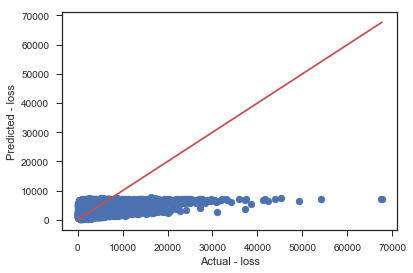

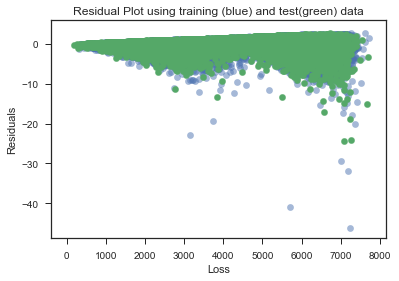

In [399]:
from scipy import stats

# Plot of predicted values versus the true values
plt.figure()
plt.scatter(y_test, estimator.predict(X_test))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.ylabel('Predicted - loss')
plt.xlabel('Actual - loss')

# Plot of residuals
plt.figure()
plt.scatter(estimator.predict(X_train), stats.zscore(estimator.predict(X_train) - y_train), c='b', s=40, alpha=0.5)
plt.scatter(estimator.predict(X_test), stats.zscore(estimator.predict(X_test) - y_test), c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=20)
plt.title('Residual Plot using training (blue) and test(green) data')
plt.ylabel('Residuals')
plt.xlabel('Loss')
plt.show()